<a href="https://colab.research.google.com/github/AugustoJunior7/Modelos-em-Redes/blob/main/Modelos_em_Redes_Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelos em Redes - Projeto**

Esse projeto para a disciplina de **Modelos em Redes** visa **extrair dados da rede social Twitter**, moldá-los como um **grafo de rede complexa**, e então estudar suas propriedades. Para uma melhor compreensão, o projeto foi dividido entre os módulos de **extração** e **estudo**, e ambos possuem comentários no seu decorrer.

# **Extração**

Essa fase do projeto é onde os dados da rede social Twitter são extraídos, a partir de um usuário "root" (a minha conta no twitter) e então obtendo os meus seguidores, os seguidores dos meus seguidores e modelando esta rede como um grafo.

Import das bibliotecas utilizadas

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy
import math 

Credenciais retiradas do app criado na API do Twitter para desenvolvedores.

In [ ]:
consumer_key = 'THIcRCbZ5MW5Cps08KUjoZhd7'
consumer_secret = 'Ex0JdP8Kz8fBjtK7p7WpqoZI8gfvW6BC0pwVaAYsRvhfssTo1v'
access_token = '264913906-Qisx2inRA3lcThAcOD01cBsEosWMJ8OKnQeP1z8d'
access_token_secret = 'fBw9Mb9t6yPJCnQMmbNN75GLuIGZfiwy1uKji74PQJiAL'

Utilizando a biblioteca Tweepy para se conectar com a API do Twitter através das credenciais obtidas.

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

Obtendo o id do meu usuário do Twitter, que será utilizado como root para criação do grafo.

In [ ]:
me = api.get_user(screen_name = "augusto1jr")
my_id = me.id

Obtendo a lista de seguidores do meu usuário através do id.

In [ ]:
user_list = [str(my_id)]
follower_list = []
for user in user_list:
    followers = []
    try:
        for page in tweepy.Cursor(api.followers_ids, user_id=user).pages():
            followers.extend(page)

    except tweepy.TweepError:
        continue
    follower_list.append(followers)

Criando um dataframe a partir dos dados coletados.

  source = "seguido" |
  target = "seguidor"

In [ ]:
df = pd.DataFrame(columns=['source','target'])
df['target'] = follower_list[0] 
df['source'] = my_id 

Transformando o dataframe em um grafo compatível com a biblioteca NetworkX.

In [ ]:
my_graph = nx.from_pandas_edgelist(df, 'source', 'target', create_using=nx.DiGraph())

Exibindo o grafo inicial, com o meu usuário como root e em volta os seus seguidores.

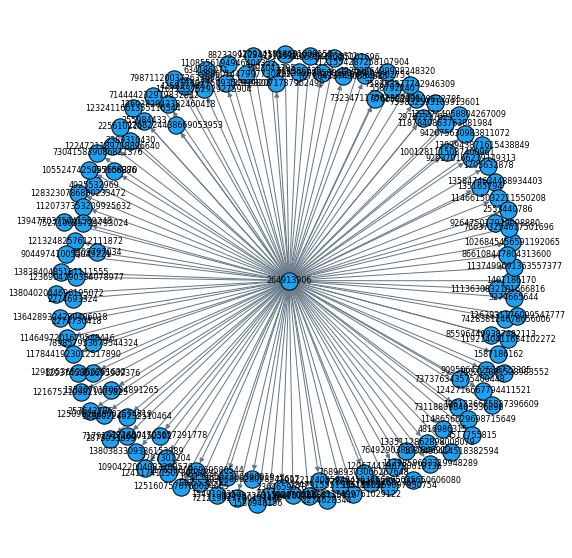

In [ ]:
pos = nx.spring_layout(my_graph)
f, ax = plt.subplots(figsize=(10, 10))
nx.draw(my_graph, pos, font_size=8, font_color="black", with_labels=True, node_color="#1DA1F2", edge_color="#657786", edgecolors="black")

Percorrendo a minha lista de seguidores e então obtendo os seguidores deles.

(são selecionados somentes os primeiros 20 seguidores de cada um, para evitar um efeito bola de neve e que a coleta possa ser realizada em um tempo razoável).

Meus seguidores: 125

Seguidores dos meus seguidores: 20 primeiros de cada

Resultado: 125 x 20 = 2500 nós (aproximadamente).

In [ ]:
user_list = list(df['target'])

for userID in user_list:
    followers = []
    follower_list = []
    user = api.get_user(userID)
    followers_count = user.followers_count
    try:
        for page in tweepy.Cursor(api.followers_ids, user_id=userID).pages():
            followers.extend(page)
            if followers_count >= 20:
                break

    except tweepy.TweepError:
        continue

    follower_list.append(followers)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list[0]
    temp['source'] = userID
    df = df.append(temp)

Rate limit reached. Sleeping for: 895
Rate limit reached. Sleeping for: 895
Rate limit reached. Sleeping for: 897
Rate limit reached. Sleeping for: 897
Rate limit reached. Sleeping for: 897
Rate limit reached. Sleeping for: 897
Rate limit reached. Sleeping for: 896
Rate limit reached. Sleeping for: 896


Outro motivo para se limitar aos 20 primeiros seguidores é que a API do Twitter só permite 15 requisições a cada 15 minutos, também por isso eu decidi salvar o dataframe em um .csv, caso precisasse acessar os dados sem ter que coletá-los novamente.

In [ ]:
df.to_csv("networkOfFollowers.csv")

Lendo o csv e transformando o dataframe em um grafo compatível com a biblioteca NetworkX.

In [ ]:
df = pd.read_csv("networkOfFollowers.csv")
brute_graph = nx.from_pandas_edgelist(df, 'source', 'target', create_using=nx.DiGraph())

In [ ]:
print("O número de nós da rede é:", nx.number_of_nodes(brute_graph))
print("O número de enlaces da rede é:", nx.number_of_edges(brute_graph))

O número de nós da rede é: 44626
O número de enlaces da rede é: 49917


O resultado gerou uma rede com cerca de 44 mil nós, que tornava dificil a execução de qualquer algoritmo de análise ou visualização da rede, além disso a rede possuía um número de enlace pouco maior que 44 mil, pois a grande maioria dos nós possuía apenas 1 enlace. 

Para contornar esse problema, usei o código abaixo para restringir os nós do grafo para somente aqueles que possuem 2 ou mais enlaces.

In [ ]:
graph = nx.k_core(brute_graph, 2)

O resultado foi uma rede menor, porém com um número bem maior de conexões entre os usuários.

In [ ]:
print("O número de nós da rede é:", nx.number_of_nodes(graph))
print("O número de enlaces da rede é:", nx.number_of_edges(graph))

O número de nós da rede é: 2370
O número de enlaces da rede é: 7668


Exibindo o grafo final que será estudado.

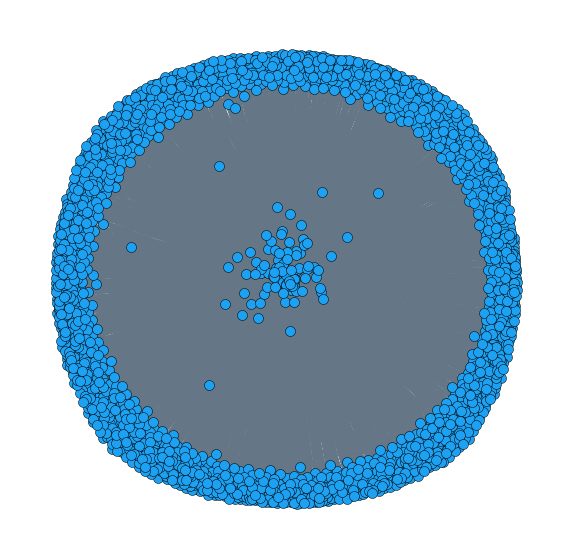

In [ ]:
pos=nx.spring_layout(graph)
f, ax = plt.subplots(figsize=(10, 10))
nx.draw(graph, pos, with_labels=False, node_size=100, node_color="#1DA1F2", edge_color="#657786", edgecolors="black")

# **Estudo**

No segundo e último módulo do projeto, a rede complexa que foi modelada servirá como base para o estudo de várias métricas, que serão interpretadas e discutidas ao longo do módulo.

### **Características da rede**

A rede modelada é do tipo fracamente conectada, contendo apenas uma componente com todos os nós.

In [ ]:
nx.is_weakly_connected(graph)

True

In [ ]:
print("O número de componentes fracamente conectadas é:", nx.number_weakly_connected_components(graph))

O número de componentes fracamente conectadas é: 1


Por outro lado, o número de componentes fortemente conectadas é muito próximo do número de nós da rede, fazendo com que praticamente todas as componentes sejam formadas por apenas 1 nó, inviabilizando a maioria das métricas que seriam calculadas, portanto, decidi seguir com a compontente fracamente conectada.

In [ ]:
print("O número de componentes fortemente conectadas é:", nx.number_strongly_connected_components(graph))

O número de componentes fortemente conectadas é: 2330


### **Métricas da rede**

>**Grau e Distribuição**

Por se tratar de um grafo direcionado, o cálculo do grau médio foi dividido entre o grau de entrada e o grau de saída.

In [ ]:
in_d = graph.in_degree()
print("O grau médio de entrada do grafo é:", np.average(in_d, 1)[1])

O grau médio de entrada do grafo é: 6.973851875207946e+17


In [ ]:
out_d = graph.out_degree()
print("O grau médio de saída do grafo é:", np.average(out_d, 1)[1])

O grau médio de saída do grafo é: 6.973851875207946e+17


O fato de ambos valores serem iguais me fez pensar se estava calculando o grau corretamente, e por isso fui verificar a distribuição do grau de entrada e de saída do grafo.

>**Grau de entrada**

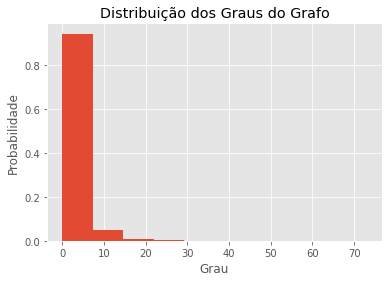

In [ ]:
deg = [d for c, d in graph.in_degree()]

plt.title("Distribuição dos Graus do Grafo")
plt.xlabel('Grau')
plt.ylabel('Probabilidade')
plt.hist(deg, weights= np.ones_like(deg) / len(deg))
plt.show()

>**Grau de saída**

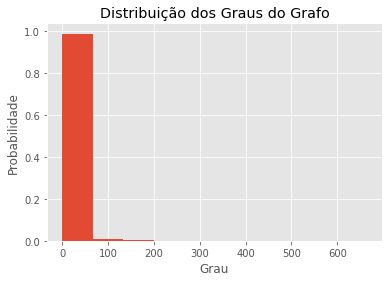

In [ ]:
deg = [d for c, d in graph.out_degree()]

plt.title("Distribuição dos Graus do Grafo")
plt.xlabel('Grau')
plt.ylabel('Probabilidade')
plt.hist(deg, weights= np.ones_like(deg) / len(deg))
plt.show()

Observando a distribuição do grau de entrada e de saída do grafo, eu pude perceber que se tratam de duas distribuições diferentes, mas com o mesmo resultado quando se trata da média.

Através dos cálculos das métricas e da observação da distribuição do grau, foi possível concluir que :

O grau de entrada da rede, representa o número de pessoas que alguém segue,
(esse número foi limitado à no máximo 20 para não causar um efeito bola de neve e criar uma rede muito grande). Ele varia de uma forma bem irregular, e mostra que a maioria dos usuários da coleta seguem poucas pessoas que representam os seus interesses específicos na rede.

Por outro lado, o grau de saída da rede, que representa o número de seguidores que alguém possui, se mantém altamente regular, onde a maioria das pessoas são seguidas por poucas pessoas, e alguns poucos usuários, que podem ser considerados os hubs (ou pessoas mais conhecidas dentro da amostra), são seguidos por grupos de 50 à 200 pessoas.

In [ ]:
Sgraph = pd.DataFrame(sorted(graph.degree, key=lambda x: x[1], reverse=True))
Sgraph.columns = ["nconst","degree"]
Sgraph[:5].degree

0    664
1    497
2    443
3    439
4    325
Name: degree, dtype: int64

Através desse código é possível observar que os hubs da rede possuem entre 300 à 600 conexões dentro do grafo (entre seguidores/seguidos).

>**Densidade**

In [ ]:
print("A densidade do grafo é:", nx.density(graph))

A densidade do grafo é: 0.0013657421012978825


A densidade da rede pareceu ser bem baixa, mas ao comparar com outras amostras de redes sociais utilizadas por mim na disciplina, constatei que ela se manteve num padrão que pode ser considerado razoável para esse tipo de rede.

>**Tamanho Médio do Caminho**

In [ ]:
print("O tamanho médio dos caminhos do grafo é:", nx.average_shortest_path_length(graph))


O tamanho médio dos caminhos do grafo é: 0.07634209809191508


O valor do tamanho médio dos caminhos do grafo me causou estranheza, pois ficou muito baixo, e também não foi possível calculá-lo através da maior componente fortemente conectada, pois representava uma fração muito pequena da rede. Para solucionar esse problema eu transformei o grafo direcionado em um grafo não direcionado.

In [ ]:
Ugraph = nx.to_undirected(graph)
print("O tamanho médio dos caminhos do grafo é:", nx.average_shortest_path_length(Ugraph))

O tamanho médio dos caminhos do grafo é: 3.1246038403926955


Dessa forma, o tamanho médio do caminho apresentou um valor muito mais realista, e refletiu uma propriedade interessante das redes sociais presente na amostra. Ele é relativamente curto (aproximadamente 3) e mostra como é fácil encontrar uma pessoa dentro da rede (ou pelo menos dentro da amostra). Teoricamente, para encontrar uma pessoa aleatória, seria necessário somente percorrer 3 nós (ou 3 usuários). Ou seja, essa pessoa aleatória ou desconhecida seria um "amigo, de um amigo, de um amigo seu".

>**Coeficiente de Aglomeração**

In [ ]:
print("O coeficiente de aglomeração do grafo é:", nx.average_clustering(graph))

O coeficiente de aglomeração do grafo é: 0.21156808004940303


Por fim, o coeficiente de aglomeração da rede também nos ensina muito sobre a rede social em questão. Ele possui valor de cerca de 0.2 e pode ser considerado bem alto. Um alto coeficiente de aglomeração mostra como a rede está disposta, e no caso do twitter (e outras redes sociais) ele reflete como as pessoas se relacionam. Em termos de grafos, existem alguns grupos de nós que estão altamente conectados entre si, com várias enlaces de curto alcance, e alguns desse nós, possuem um enlace de longo alcance que o conecta com outros grupos de nós densamente conectados. Trazendo para o mundo real, isso mostra que os usuários geralmente tem um grupo de amigos que possuem vários amigos em comum, e alguns desse amigos se conectam à outros grupos de amigos em comum.

>**Extra: Detecção de Comunidades**

Uma das áreas do estudo de redes que mais me chamou atenção, foi a detecção de comunidades, portanto, decidi verificar essas propriedades na rede modelada que representa o meu twitter.

In [ ]:
from community import community_louvain

partition = community_louvain.best_partition(Ugraph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['user','group']

Separando os nós e os agrupando em comunidades, para isso foi utilizada uma versão não direcionada do grafo pois só assim é possível executar os algoritmos de detecção de comunidades.

In [ ]:
df2 = pd.DataFrame(sorted(Ugraph.degree, key=lambda x: x[1], reverse=True))
df2.columns = ['user','degree']

Criando um dataframe do grafo compatível com o que foi criado anteriormente.

In [ ]:
combined = pd.merge(df2, partition1, how='left', left_on="user",right_on="user")
Cgraph = nx.from_pandas_edgelist(df2, 'user', 'degree')

Fazendo o merge do dataframe de comunidades com o dataframe do grafo através da coluna identificadora 'user'.

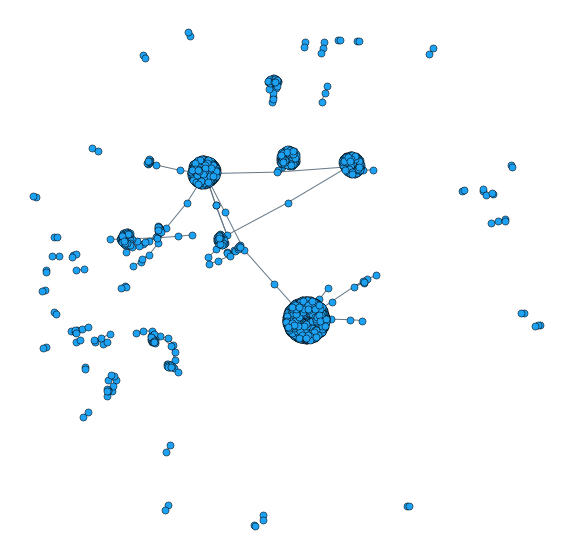

In [ ]:
pos = nx.spring_layout(Cgraph)
f, ax = plt.subplots(figsize=(10, 10))
nx.draw(Cgraph, pos, cmap=plt.cm.Set1, with_labels=False, node_size=50, node_color="#1DA1F2", edge_color="#657786", edgecolors="black")

O resultado apresentou uma grande comunidade com a maioria dos nós, algumas pequenas comunidades com uma quantidade razoável de nós, e alguns poucos nós avulsos, que não se conectaram à nenhuma comunidade.

Através dele é possível observar como os nós tendem a formar comunidades altamente conectadas entre si, mas que se apresentam isoladas do restante do grafo, sendo alguns poucos nós resposáveis pelas conexões entre as comunidades. 

Trazendo essas observações para um contexto real, a detecção de comunidades mostra que redes sociais tendem a formar grupos de amigos unidos por algo em comum, e esses grupos se conectam através de alguns poucos amigos intermediários que fazem parte dos dois ou mais grupos. Além disso, os nós que ficaram isolados podem ser interpretados como contas antigas, bots ou simplesmente pessoas que conheceram "aleatóriamente" alguém da coleta e não compartilham muitos seguidores com o restante da amostra.

Esse resultado me deixou curioso para buscar respostas em algum trabalho futuro, onde as comunidades poderiam ser estudadas para entender quais são seus tipos de membros, e quais são os conteúdos que unem os usuários que fazem parte dela.